In [36]:
## define imports

#  number crunching
import numpy as np
import math

# torch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output

# helper
import time

In [37]:
results = []

In [38]:
## setting hyperparameters
hp_test = 'lr = 3.5e-01'
learning_rate = 3.5e-01
epochs = 400
middle_layer = 16
batch_size = 25
data_step = .5
data_min = -5
data_max = 5

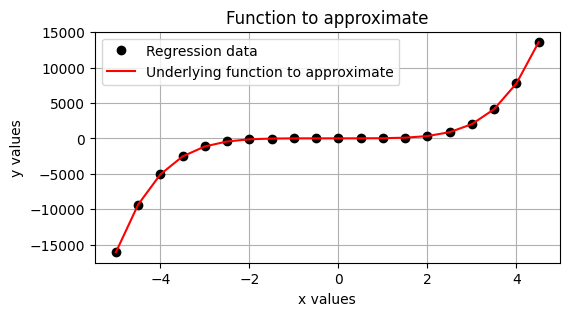

In [39]:
## create polynomial data
def function(x):
    return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)


xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(xi)

inputs = xi.shape[1]    
yi = yi.reshape(-1, 1)


# show approximation curve
plt.figure(figsize=(6,3))
plt.plot(xi, yi, 'o', color='black', label='Regression data')
plt.plot(xi, yi, color='red', label='Underlying function to approximate')
plt.title('Function to approximate')
plt.xlabel('x values')
plt.ylabel('y values')
plt.grid()
plt.legend()
plt.show()

In [40]:
### generate torch tensor dataset

## transform to tensor
tensor_x = torch.Tensor(xi)
tensor_y = torch.Tensor(yi)

# create dataset
dataset = TensorDataset(tensor_x, tensor_y)

# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [41]:
## build the model
class Net(nn.Module):
    def __init__(self, inputs, middle):
        super().__init__()
        
        self.fc1 = nn.Linear(inputs, middle)
        self.fc2 = nn.Linear(middle, middle)
        self.out = nn.Linear(middle, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return x

In [42]:
## create the model
model = Net(inputs, middle_layer)
print(model)

Net(
  (fc1): Linear(in_features=1, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


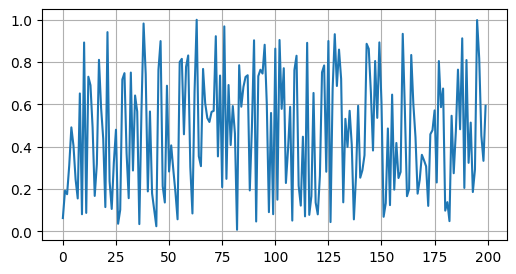

tensor([[0.1238],
        [0.1144],
        [0.1156],
        [0.1059],
        [0.0927],
        [0.0995],
        [0.1105],
        [0.1170],
        [0.0712],
        [0.1225],
        [0.0495],
        [0.1220],
        [0.0617],
        [0.0665],
        [0.0928],
        [0.1162],
        [0.1055],
        [0.0542],
        [0.0799],
        [0.0971],
        [0.1200],
        [0.0467],
        [0.1111],
        [0.1206],
        [0.1049],
        [0.0942],
        [0.1263],
        [0.1209],
        [0.0633],
        [0.0593],
        [0.1019],
        [0.1169],
        [0.0590],
        [0.1076],
        [0.0723],
        [0.0824],
        [0.1265],
        [0.0821],
        [0.0443],
        [0.0600],
        [0.1146],
        [0.0823],
        [0.1153],
        [0.1209],
        [0.1280],
        [0.0577],
        [0.0491],
        [0.1128],
        [0.1184],
        [0.0668],
        [0.1079],
        [0.0993],
        [0.1074],
        [0.1149],
        [0.1242],
        [0

In [43]:
## push random data through model for debugging
data = np.random.random((200, 1))
data.shape

plt.figure(figsize=(6,3))
plt.plot(data)
plt.grid()
plt.show()

model(torch.Tensor(data))

In [44]:
## define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

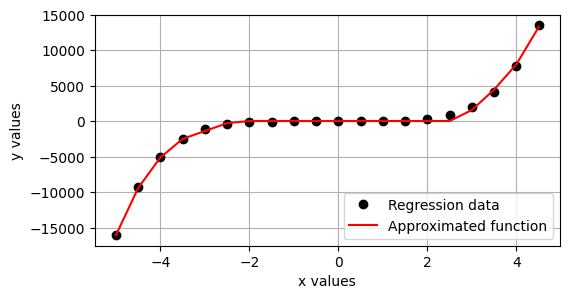

[399] Loss = 68815.234375


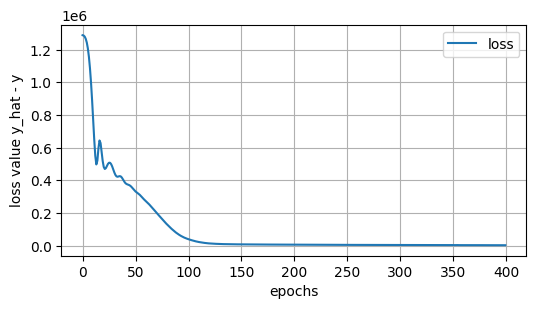

In [45]:
## train the model
epoch_report = 5
history = []
start = time.time()

for i in range(epochs):
    for x, y in iter(dataloader):
    
    # NOTE: Mike does not use iter() on the dataloader and does not use Variable()
    # e.g. section 131 of mike
        
        # wrap data in variables
        x_batch = Variable(torch.Tensor(x))
        y_batch = Variable(torch.Tensor(y))
        
        # forward pass
        y_pred = model(x_batch)
        
        # compute and print loss
        loss = loss_fn(y_pred, y_batch)
        history.append(loss.data/batch_size)
        
        # reset gradients
        optimizer.zero_grad()   
        
        # backwards pass
        loss.backward()
        
        # step the optimizer (update the weights)
        optimizer.step()
      
      
    if (i+1) % epoch_report == 0:
        clear_output()
        
        y_ = model(tensor_x)
        plt.figure(figsize=(6,3))
        plt.plot(xi, yi, 'ko', label='Regression data')
        plt.plot(xi, y_.detach().numpy(), 'r', label='Approximated function')
        plt.xlabel('x values')
        plt.ylabel('y values')
        plt.grid()
        plt.legend(loc='lower right')
        plt.show()
        
        print(f'[{i}] Loss = {loss.data}')
        time.sleep(1)

plt.figure(figsize=(6,3))   
plt.plot(history, label='loss')
plt.xlabel('epochs')
plt.ylabel('loss value y_hat - y')
plt.legend()
plt.grid()
plt.show()

end = time.time() - start      

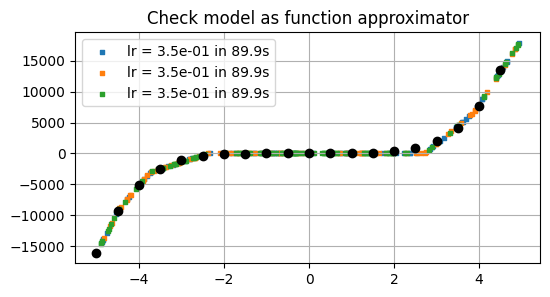

In [48]:
## check trained model

x_a = torch.rand(100, 1).clone() * 10 - 5   
y_a = model(x_a)
y_a = y_a.detach().numpy()
results.append([hp_test, end, x_a, y_a])

fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(111)
for test,t,x,y in results:
    ax1.scatter(x, y, s=10, marker="s", label=f"{test} in {t:0.1f}s")

plt.title('Check model as function approximator')
plt.legend(loc='upper left')
plt.plot(xi, yi, 'o', color='black')
plt.grid()
plt.show()